<a href="https://colab.research.google.com/github/saivishwanathgoud/MachineLearning/blob/master/ITSM_Incident_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ITSM Incident Analysis**

1. Predicting Priorities: The predictor variables are Category, CI Category, CI Subcategory & WBS
2. Predicting Request for Change (RFC): The predictor variables are Category, CI Subcategory, WBS, Priority, Number of Related Interaction, Number of Related Incidents
3. Forecasting the Incident Volume: The predictor variable is opening time.

In [1]:
#importing the required libraries 
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
import statsmodels.api as sm
from sklearn.externals import joblib
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
#importing data into pandas dataframe 
df = pd.read_csv('ITSM_data.txt')
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,Category,KB_number,Alert_Status,No_of_Reassignments,Open_Time,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,incident,KM0000553,closed,26.0,5/2/2012 13:32,NaN,4/11/2013 13:50,4/11/2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,incident,KM0000611,closed,33.0,12/3/2012 15:44,2/12/2013 12:31,2/12/2013 12:36,2/12/2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,request for information,KM0000339,closed,3.0,29-03-2012 12:36,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,incident,KM0000611,closed,13.0,17-07-2012 11:49,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,incident,KM0000611,closed,2.0,10/8/2012 11:01,NaN,8/11/2013 13:55,8/11/2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [3]:
#number of rows and columns in dataset
df.shape

(46606, 25)

In [4]:
#checking the columns 
df.columns

Index(['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status',
       'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number',
       'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Reopen_Time',
       'Resolved_Time', 'Close_Time', 'Handle_Time_hrs', 'Closure_Code',
       'No_of_Related_Interactions', 'Related_Interaction',
       'No_of_Related_Incidents', 'No_of_Related_Changes', 'Related_Change'],
      dtype='object')

In [5]:
#checking for datatypes and missing values 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Name                     46606 non-null  object 
 1   CI_Cat                      46495 non-null  object 
 2   CI_Subcat                   46495 non-null  object 
 3   WBS                         46606 non-null  object 
 4   Incident_ID                 46606 non-null  object 
 5   Status                      46606 non-null  object 
 6   Impact                      46606 non-null  object 
 7   Urgency                     46606 non-null  object 
 8   Priority                    45226 non-null  float64
 9   number_cnt                  46606 non-null  float64
 10  Category                    46606 non-null  object 
 11  KB_number                   46606 non-null  object 
 12  Alert_Status                46606 non-null  object 
 13  No_of_Reassignments         466

In [6]:
df.isnull().sum()

CI_Name                           0
CI_Cat                          111
CI_Subcat                       111
WBS                               0
Incident_ID                       0
Status                            0
Impact                            0
Urgency                           0
Priority                       1380
number_cnt                        0
Category                          0
KB_number                         0
Alert_Status                      0
No_of_Reassignments               1
Open_Time                         0
Reopen_Time                   44322
Resolved_Time                  1780
Close_Time                        0
Handle_Time_hrs                   1
Closure_Code                    460
No_of_Related_Interactions      114
Related_Interaction               0
No_of_Related_Incidents       45384
No_of_Related_Changes         46046
Related_Change                46046
dtype: int64

In [10]:
df.CI_Cat.value_counts()

application             32900
subapplication           7782
computer                 3643
storage                   703
hardware                  442
software                  333
database                  214
displaydevice             212
officeelectronics         152
networkcomponents         107
applicationcomponent        5
Phone                       2
Name: CI_Cat, dtype: int64

In [11]:
df.CI_Subcat.value_counts()

Server Based Application    18811
Web Based Application       15311
Desktop Application          3876
Laptop                       1921
SAP                          1199
                            ...  
Neoview Server                  1
VMWare                          1
RAC Service                     1
UPS                             1
Protocol                        1
Name: CI_Subcat, Length: 64, dtype: int64

**Data Processing / Data Munging**

CI Category & CI Subcategory had a lot of labels which were replaced to only take the major ones. Unknown values were replaced by Mode values.

In [13]:
df.CI_Cat.replace(['database'],'storage',inplace=True)
df.CI_Cat.replace(['applicationcomponent'],'subapplication',inplace=True)
df.CI_Cat.replace(['displaydevice','officeelectronics','Phone','networkcomponents'],'hardware',inplace=True)
df.CI_Cat.replace(np.nan,'application',inplace=True)

In [14]:
df.CI_Subcat.replace('Desktop','Desktop Application',inplace=True)
df.CI_Subcat.replace(['Application Server','Virtual Tape Server','ESX Server','zOS Server','Neoview Server','X86 Server',
                       'Unix Server','Oracle Server','Windows Server in extern beheer','Thin Client','NonStop Server',
                       'Number','Windows Server','Linux Server',np.nan,'SharePoint Farm','Lines'],
                       'Server Based Application',inplace=True)
df.CI_Subcat.replace('RAC Service','Banking Device',inplace=True)
df.CI_Subcat.replace(['Iptelephony','Protocol','Net Device','IPtelephony','ESX Cluster','Standard Application'],
                       'Web Based Application',inplace=True)
df.CI_Subcat.replace(['VMWare','Security Software','zOS Systeem','Firewall','Database Software','VDI','Instance',
                       'MQ Queue Manager','Automation Software','Citrix','SAP','Encryption'],'System Software',inplace=True)
df.CI_Subcat.replace(['UPS','Omgeving'],'Client Based Application',inplace=True)
df.CI_Subcat.replace(['NonStop Storage','NonStop Harddisk','Tape Library','zOS Cluster','DataCenterEquipment',
                       'MigratieDummy'],'Database',inplace=True)
df.CI_Subcat.replace(['Modem','Router'],'Network Component',inplace=True)
df.CI_Subcat.replace('KVM Switches','Switch',inplace=True)

In [15]:
df.No_of_Related_Interactions.replace(np.nan,1,inplace=True)
df.Priority.replace(np.nan,4,inplace=True)
df.No_of_Related_Incidents.replace(np.nan,0,inplace=True)
df.No_of_Related_Changes.replace(np.nan,0,inplace=True)

# Predicting Priorities

**Feature Selection**

Only the features which are available when the tickets arrives can be used to predict priority. Therefore, we have used only 4 predictors.

In [17]:
X = df.loc[:,['CI_Cat','CI_Subcat','WBS','Category']]
y = df.Priority

In [19]:
X.head(3)

,CI_Cat,CI_Subcat,WBS,Category
0,subapplication,Web Based Application,WBS000162,incident
1,application,Web Based Application,WBS000088,incident
2,application,Desktop Application,WBS000092,request for information


In [20]:
# Label Encoding
enc= LabelEncoder()
for i in (0,1,2,3):
    X.iloc[:,i] = enc.fit_transform(X.iloc[:,i])

In [23]:
# Splitting the data into test and train for calculating accuracy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=10)

In [24]:
# Standardization technique
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [25]:
X_train.shape


(32624, 4)

In [26]:
X_test.shape

(13982, 4)

# Models 

**1.Support Vector Machine**

In [27]:
# Training the model
from sklearn.svm import SVC
rbf_svc = SVC(kernel='rbf',C=10,gamma=0.1).fit(X_train,y_train)

In [28]:
# Predicting the model
y_predict_svm = rbf_svc.predict(X_test)

In [29]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_svm))
print(classification_report(y_test,y_predict_svm))

0.747604062365899
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.65      0.58       210
         3.0       0.55      0.31      0.39      1581
         4.0       0.72      0.89      0.80      7254
         5.0       0.87      0.68      0.76      4936

    accuracy                           0.75     13982
   macro avg       0.53      0.51      0.51     13982
weighted avg       0.75      0.75      0.74     13982



In [30]:
confusion_matrix(y_test,y_predict_svm)

array([[   0,    0,    0,    1,    0],
       [   0,  137,    8,   56,    9],
       [   0,   36,  486,  958,  101],
       [   0,   78,  314, 6477,  385],
       [   0,   10,   79, 1494, 3353]])

**2.Decision Tree**

In [31]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model_dtree=DecisionTreeClassifier()
model_dtree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
# Predicting the model
y_predict_dtree = model_dtree.predict(X_test)

In [33]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_dtree))
print(classification_report(y_test,y_predict_dtree))

0.81690745243885
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.69      0.59       210
         3.0       0.66      0.63      0.65      1581
         4.0       0.82      0.87      0.85      7254
         5.0       0.88      0.80      0.84      4936

    accuracy                           0.82     13982
   macro avg       0.58      0.60      0.58     13982
weighted avg       0.82      0.82      0.82     13982



In [34]:
confusion_matrix(y_test,y_predict_dtree)


array([[   0,    0,    0,    1,    0],
       [   0,  144,    6,   43,   17],
       [   0,   42,  999,  419,  121],
       [   0,   80,  458, 6325,  391],
       [   0,   12,   51,  919, 3954]])

**3.Random Forest**

In [35]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(max_depth=27)
model_rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=27, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
# Predicting the model
y_predict_rf = model_rf.predict(X_test)

In [37]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_rf))
print(classification_report(y_test,y_predict_rf))

0.8164783292805035
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.67      0.58       210
         3.0       0.66      0.62      0.64      1581
         4.0       0.82      0.87      0.85      7254
         5.0       0.88      0.80      0.84      4936

    accuracy                           0.82     13982
   macro avg       0.58      0.59      0.58     13982
weighted avg       0.82      0.82      0.82     13982



In [38]:
confusion_matrix(y_test,y_predict_rf)

array([[   0,    0,    0,    1,    0],
       [   0,  140,    9,   44,   17],
       [   0,   40,  986,  433,  122],
       [   0,   78,  451, 6332,  393],
       [   0,   11,   48,  919, 3958]])

**4.K-Nearest Neighbor**

In [39]:
# Training the model
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=12,metric='euclidean') # Maximum accuracy for n=10
model_knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=12, p=2,
                     weights='uniform')

In [40]:
# Predicting the model
y_predict_knn = model_knn.predict(X_test)

In [41]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_knn))
print(classification_report(y_test,y_predict_knn))

0.8133314261192962
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.51      0.67      0.58       210
         3.0       0.66      0.62      0.64      1581
         4.0       0.81      0.87      0.84      7254
         5.0       0.88      0.79      0.84      4936

    accuracy                           0.81     13982
   macro avg       0.57      0.59      0.58     13982
weighted avg       0.82      0.81      0.81     13982



In [42]:
confusion_matrix(y_test,y_predict_knn)


array([[   0,    0,    0,    1,    0],
       [   0,  141,    7,   47,   15],
       [   0,   42,  986,  432,  121],
       [   0,   80,  460, 6339,  375],
       [   0,   14,   51,  965, 3906]])

**5.XGBOOST Classifier**

In [43]:
# Training the model
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [44]:
# Predicting the model
y_predict_xgb = model_xgb.predict(X_test)

In [45]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_xgb))
print(classification_report(y_test,y_predict_xgb))

0.7924474324131026
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.53      0.65      0.59       210
         3.0       0.67      0.41      0.51      1581
         4.0       0.77      0.89      0.83      7254
         5.0       0.87      0.77      0.82      4936

    accuracy                           0.79     13982
   macro avg       0.57      0.55      0.55     13982
weighted avg       0.79      0.79      0.79     13982



In [46]:
confusion_matrix(y_test,y_predict_xgb)

array([[   0,    0,    0,    1,    0],
       [   0,  137,    3,   56,   14],
       [   0,   36,  647,  776,  122],
       [   0,   75,  267, 6492,  420],
       [   0,   10,   46, 1076, 3804]])

**6.Artificial Neural Networks**

In [47]:
# Training the model
from sklearn.neural_network import MLPClassifier
model_mlp = MLPClassifier()
model_mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [48]:
# Predicting the model
y_predict_mlp = model_mlp.predict(X_test)

In [49]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y_test,y_predict_mlp))
print(classification_report(y_test,y_predict_mlp))

0.7677013302817909
              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         1
         2.0       0.52      0.65      0.58       210
         3.0       0.61      0.39      0.48      1581
         4.0       0.75      0.89      0.81      7254
         5.0       0.87      0.72      0.79      4936

    accuracy                           0.77     13982
   macro avg       0.55      0.53      0.53     13982
weighted avg       0.77      0.77      0.76     13982



In [50]:
confusion_matrix(y_test,y_predict_mlp)

array([[   0,    0,    0,    1,    0],
       [   0,  137,    6,   55,   12],
       [   0,   36,  620,  817,  108],
       [   0,   78,  339, 6421,  416],
       [   0,   10,   53, 1317, 3556]])

In [51]:
# Exporting the trained model
joblib.dump(model_rf,'Predicting_Priority.ml')

['Predicting_Priority.ml']

# 2. Predicting Request For Change (RFC)

Feature Selection

In [52]:
# Selecting the predictors
X1 = df.loc[:,['CI_Subcat','WBS','Priority','Category','No_of_Related_Interactions','No_of_Related_Incidents']]
y1 = df.No_of_Related_Changes

In [53]:
X1.head(2)

,CI_Subcat,WBS,Priority,Category,No_of_Related_Interactions,No_of_Related_Incidents
0,Web Based Application,WBS000162,4.0,incident,1.0,2.0
1,Web Based Application,WBS000088,3.0,incident,1.0,1.0


In [54]:
enc= LabelEncoder()
for i in (0,1,3,4):
    X1.iloc[:,i] = enc.fit_transform(X1.iloc[:,i])

In [55]:
# Splitting into train and test for calculating the accuracy
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.3,random_state=10)

In [56]:
# Standardization technique is used
sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

In [57]:
X1_train.shape


(32624, 6)

In [58]:
X1_test.shape

(13982, 6)

# **Models**

**1.Decision Tree**

In [59]:
# Training the model
from sklearn.tree import DecisionTreeClassifier
model1_dtree=DecisionTreeClassifier()
model1_dtree.fit(X1_train,y1_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [60]:
# Predicting the model
y1_predict_dtree = model1_dtree.predict(X1_test)

In [61]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y1_test,y1_predict_dtree))
print(classification_report(y1_test,y1_predict_dtree))

0.9886282363038192
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13835
         1.0       0.22      0.03      0.05       138
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         1
         9.0       0.00      0.00      0.00         0

    accuracy                           0.99     13982
   macro avg       0.24      0.21      0.21     13982
weighted avg       0.98      0.99      0.98     13982



In [62]:
confusion_matrix(y1_test,y1_predict_dtree)

array([[13819,    14,     1,     0,     1],
       [  134,     4,     0,     0,     0],
       [    8,     0,     0,     0,     0],
       [    1,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0]])

**2.Random Forest**

In [63]:
# Training the model
from sklearn.ensemble import RandomForestClassifier
model1_rf = RandomForestClassifier()
model1_rf.fit(X1_train,y1_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
# Predicting the model
y1_predict_rf = model1_rf.predict(X1_test)

In [65]:
# Finding accuracy, precision, recall and confusion matrix
print(accuracy_score(y1_test,y1_predict_rf))
print(classification_report(y1_test,y1_predict_rf))

0.9891288799885567
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     13835
         1.0       0.22      0.01      0.03       138
         2.0       0.00      0.00      0.00         8
         3.0       0.00      0.00      0.00         1

    accuracy                           0.99     13982
   macro avg       0.30      0.25      0.26     13982
weighted avg       0.98      0.99      0.98     13982



In [66]:
confusion_matrix(y1_test,y1_predict_rf)

array([[13828,     7,     0,     0],
       [  136,     2,     0,     0],
       [    8,     0,     0,     0],
       [    1,     0,     0,     0]])

In [67]:
# Exporting the trained model
joblib.dump(model1_dtree,'Predict_RFC.ml')

['Predict_RFC.ml']

# **3.Forecasting the Incident Volume**

In [69]:
# Imporing the necessary columns
frq = df.loc[:,['Incident_ID','Open_Time']]

In [70]:
frq.head()

,Incident_ID,Open_Time
0,IM0000004,5/2/2012 13:32
1,IM0000005,12/3/2012 15:44
2,IM0000006,29-03-2012 12:36
3,IM0000011,17-07-2012 11:49
4,IM0000012,10/8/2012 11:01


In [72]:
# Coverting all the values in proper Datetime format
for i in range(len(frq.Open_Time)):
    if (frq.Open_Time[i][1]=='/'):
        frq.Open_Time[i] = dt.datetime.strptime(frq.Open_Time[i],'%d/%m/%Y %H:%M').date()
    elif (frq.Open_Time[i][2]=='/'):
        frq.Open_Time[i] = dt.datetime.strptime(frq.Open_Time[i],'%d/%m/%Y %H:%M').date()
    else:
        frq.Open_Time[i] = dt.datetime.strptime(frq.Open_Time[i],'%d-%m-%Y %H:%M').date()

In [73]:
frq.head()

,Incident_ID,Open_Time
0,IM0000004,2012-02-05
1,IM0000005,2012-03-12
2,IM0000006,2012-03-29
3,IM0000011,2012-07-17
4,IM0000012,2012-08-10


In [74]:
# Adding a new column which will have the number of tickets per day
frq['No_Incidents'] = frq.groupby('Open_Time')['Incident_ID'].transform('count')

In [75]:
frq.drop(['Incident_ID'],axis=1,inplace=True)
frq.drop_duplicates(inplace=True)

In [76]:
frq.head()

,Open_Time,No_Incidents
0,2012-02-05,1
1,2012-03-12,1
2,2012-03-29,1
3,2012-07-17,1
4,2012-08-10,2


In [77]:
# Setting Date as the Index
frq =frq.set_index('Open_Time')
frq.index = pd.to_datetime(frq.index)
frq.index

DatetimeIndex(['2012-02-05', '2012-03-12', '2012-03-29', '2012-07-17',
               '2012-08-10', '2012-08-15', '2012-08-22', '2012-08-29',
               '2012-09-03', '2012-09-21',
               ...
               '2014-03-22', '2014-03-24', '2014-03-23', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=331, freq=None)

In [78]:
frq.head(3)

,No_Incidents
Open_Time,
2012-02-05,1
2012-03-12,1
2012-03-29,1


In [79]:
# Checking range of dates for our values
print(frq.index.min(),'to',frq.index.max())

2012-02-05 00:00:00 to 2014-03-31 00:00:00


In [80]:
# Making a new Series with frequency as Day
data1 = frq['No_Incidents']
data1 = data1.asfreq('D')
data1.index

DatetimeIndex(['2012-02-05', '2012-02-06', '2012-02-07', '2012-02-08',
               '2012-02-09', '2012-02-10', '2012-02-11', '2012-02-12',
               '2012-02-13', '2012-02-14',
               ...
               '2014-03-22', '2014-03-23', '2014-03-24', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=786, freq='D')

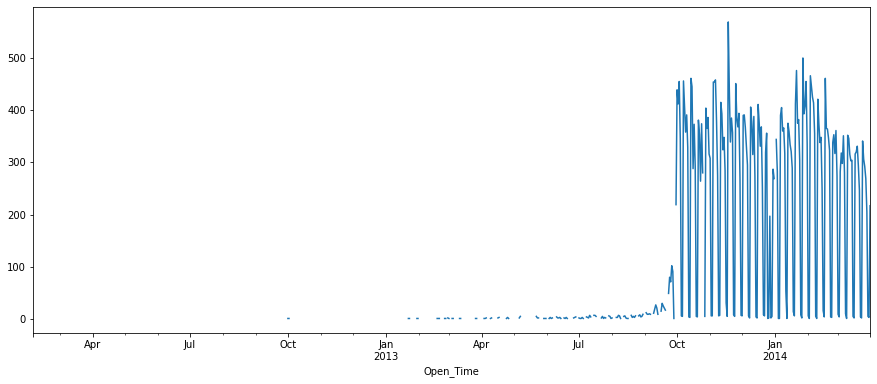

In [81]:
# Plotting number of tickets per day
data1.plot(figsize=(15,6))
plt.show()

In [83]:
# Since not many tickets before October 2013, we consider only the latter values
incfrom2013 = frq[frq.index > dt.datetime(2013,10,1)]

In [84]:
data2 = incfrom2013['No_Incidents']
data2 = data2.asfreq('D')
data2.index

DatetimeIndex(['2013-10-02', '2013-10-03', '2013-10-04', '2013-10-05',
               '2013-10-06', '2013-10-07', '2013-10-08', '2013-10-09',
               '2013-10-10', '2013-10-11',
               ...
               '2014-03-22', '2014-03-23', '2014-03-24', '2014-03-25',
               '2014-03-26', '2014-03-27', '2014-03-28', '2014-03-29',
               '2014-03-30', '2014-03-31'],
              dtype='datetime64[ns]', name='Open_Time', length=181, freq='D')

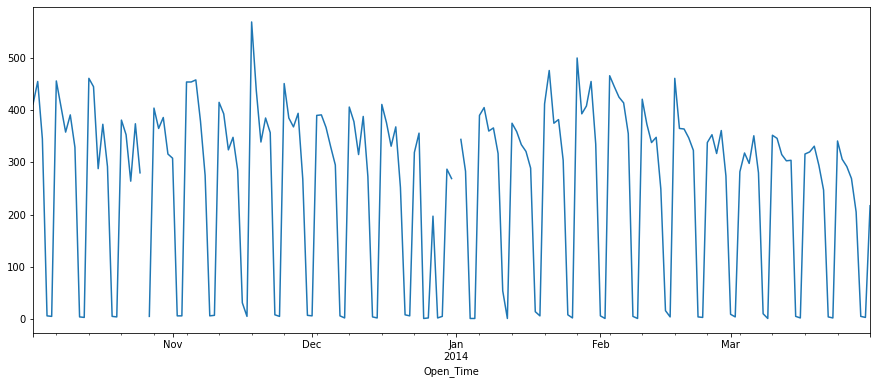

In [85]:
# Plotting number of tickets per day after October 2013
data2.plot(figsize=(15,6))
plt.show()

In [86]:
# Making a list of values for p,d & q
p = d = q = range(0,2)
pdq = list(itertools.product(p,d,q))

In [87]:
# Choosing the model with minimum AIC and the ARIMA Model for Time Series Forecasting
mod = sm.tsa.statespace.SARIMAX(data2,order=(1,1,1))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3386      0.090      3.771      0.000       0.163       0.515
ma.L1         -0.9989      0.428     -2.332      0.020      -1.839      -0.159
sigma2       2.52e+04   9781.689      2.576      0.010    6023.597    4.44e+04


In [88]:
# Predicting the future values and the confidence interval
pred = results.get_prediction(start=pd.to_datetime('2014-3-3'),end=pd.to_datetime('2014-10-30'),dynamic=False)
pred_ci = pred.conf_int()
pred.predicted_mean.round()

2014-03-03    172.0
2014-03-04    266.0
2014-03-05    279.0
2014-03-06    272.0
2014-03-07    291.0
              ...  
2014-10-26    252.0
2014-10-27    252.0
2014-10-28    252.0
2014-10-29    252.0
2014-10-30    252.0
Freq: D, Length: 242, dtype: float64

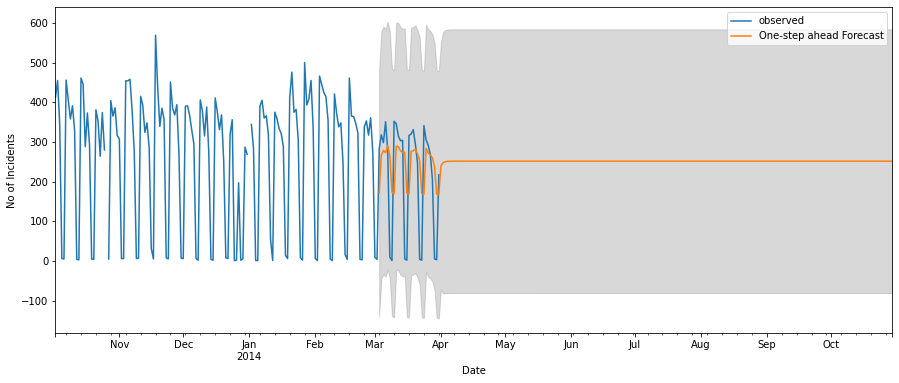

In [89]:
ax = data2['2013':].plot(label='observed')
pred.predicted_mean.plot(ax=ax,label='One-step ahead Forecast',figsize=(15, 6))
ax.fill_between(pred_ci.index,pred_ci.iloc[:,0],pred_ci.iloc[:,1],color='grey',alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('No of Incidents')
plt.legend()
plt.show()